 Import, lecture des fichiers MovieLens (ratings, items, genres), construction de dictionnaires utiles (titles, listes d'items/users) et affichage d'un head.

In [1]:
import os, re, time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

DATA_DIR = "ml-100k"  # adapte si besoin

ratings = pd.read_csv(
    os.path.join(DATA_DIR, "u.data"),
    sep="\t",
    names=["user_id","item_id","rating","timestamp"]
)

genres = pd.read_csv(os.path.join(DATA_DIR, "u.genre"), sep="|", names=["genre","genre_id"]).dropna()
genre_names = genres["genre"].tolist()
item_cols = ["item_id","title","release_date","video_release_date","imdb_url"] + genre_names

items = pd.read_csv(
    os.path.join(DATA_DIR, "u.item"),
    sep="|",
    names=item_cols,
    encoding="latin-1"
)

# dictionnaires utiles
item_id_to_title = dict(zip(items["item_id"], items["title"]))
all_users = ratings["user_id"].unique()
all_items = ratings["item_id"].unique()

ratings.head()


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


1) Split train/test (comme en cours) + users de test fixes

👉 On split ratings et on construit tout uniquement sur TRAIN.

In [2]:
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

# users test = 5 users qui ont au moins 1 interaction en test
test_users = test_df["user_id"].value_counts().head(5).index.tolist()
test_users


[405, 655, 13, 450, 276]

2) Métriques communes (Top-K + RMSE)
2.1 RMSE (sur prédiction de notes)

In [3]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


2.2 Precision@K / Recall@K / NDCG@K (Top-N)

On considère comme relevant les items du test avec note ≥ 4

In [4]:
def dcg_at_k(rels, k):
    rels = np.asarray(rels)[:k]
    if rels.size == 0:
        return 0.0
    return np.sum((2**rels - 1) / np.log2(np.arange(2, rels.size + 2)))

def ndcg_at_k(recommended_items, relevant_items, k=10):
    rels = [1 if i in relevant_items else 0 for i in recommended_items[:k]]
    dcg = dcg_at_k(rels, k)
    idcg = dcg_at_k(sorted(rels, reverse=True), k)
    return 0.0 if idcg == 0 else dcg / idcg

def precision_recall_ndcg_at_k(reco_dict, test_df, k=10, rel_threshold=4):
    # reco_dict: {user_id: [item_id1, item_id2, ...]}
    precisions, recalls, ndcgs = [], [], []
    for u, recos in reco_dict.items():
        relevant = set(test_df[(test_df.user_id==u) & (test_df.rating>=rel_threshold)]["item_id"].tolist())
        if len(relevant) == 0:
            continue
        recos_k = recos[:k]
        hit = len(set(recos_k) & relevant)
        precisions.append(hit / k)
        recalls.append(hit / len(relevant))
        ndcgs.append(ndcg_at_k(recos_k, relevant, k))
    return {
        f"Precision@{k}": float(np.mean(precisions)) if precisions else np.nan,
        f"Recall@{k}": float(np.mean(recalls)) if recalls else np.nan,
        f"NDCG@{k}": float(np.mean(ndcgs)) if ndcgs else np.nan,
    }


3) Session 4 — Matrix Factorization

Entraînement + RMSE + Top-10 reco

In [5]:
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd

# train_df, test_df déjà définis
users = np.sort(train_df.user_id.unique())
items_ = np.sort(train_df.item_id.unique())
u2i = {u:i for i,u in enumerate(users)}
it2i = {it:i for i,it in enumerate(items_)}

rows = train_df.user_id.map(u2i).values
cols = train_df.item_id.map(it2i).values
vals = train_df.rating.values.astype(float)

R_ui = coo_matrix((vals, (rows, cols)), shape=(len(users), len(items_))).tocsr()

svd = TruncatedSVD(n_components=50, random_state=42)
U = svd.fit_transform(R_ui)          # (n_users, k)
V = svd.components_.T                # (n_items, k)

# prédiction d'une note = dot(U[u], V[i])
def predict_svd(u, it):
    if u not in u2i or it not in it2i:
        return np.nan
    return float(U[u2i[u]].dot(V[it2i[it]]))

# RMSE sur test
preds = []
ytrue = []
for r in test_df.itertuples():
    p = predict_svd(r.user_id, r.item_id)
    if not np.isnan(p):
        preds.append(p)
        ytrue.append(r.rating)

preds = np.array(preds)
# on clip entre 1 et 5
preds = np.clip(preds, 1, 5)

# rename to avoid shadowing the rmse function
svd_rmse = np.sqrt(np.mean((np.array(ytrue) - preds)**2))
svd_rmse


np.float64(2.4988932656602927)

Fonction recommend(u) Top-10 (SVD)

In [6]:
def recommend_svd_truncated(user_id, train_df, all_items, u2i, it2i, U, V, n_rec=10):
    # si user inconnu
    if user_id not in u2i:
        return []

    # items déjà vus dans TRAIN
    seen = set(train_df[train_df.user_id == user_id]["item_id"].tolist())

    # candidats = items présents dans it2i (car V construit sur items train)
    candidates = [it for it in all_items if (it in it2i) and (it not in seen)]
    if not candidates:
        return []

    uvec = U[u2i[user_id]]  # (k,)

    # scores = dot(uvec, V[item])
    scored = []
    for it in candidates:
        score = float(uvec.dot(V[it2i[it]]))
        scored.append((it, score))

    scored.sort(key=lambda x: x[1], reverse=True)
    return [it for it,_ in scored[:n_rec]]


In [49]:
svd_recos = {
    u: recommend_svd_truncated(
        user_id=u,
        train_df=train_df,
        all_items=all_items,
        u2i=u2i,
        it2i=it2i,
        U=U,
        V=V,
        n_rec=10
    )
    for u in test_users
}

print(svd_recos)


{405: [np.int64(69), np.int64(393), np.int64(82), np.int64(56), np.int64(66), np.int64(238), np.int64(403), np.int64(479), np.int64(187), np.int64(44)], 655: [np.int64(180), np.int64(198), np.int64(482), np.int64(289), np.int64(61), np.int64(421), np.int64(218), np.int64(204), np.int64(238), np.int64(177)], 13: [np.int64(510), np.int64(15), np.int64(467), np.int64(530), np.int64(63), np.int64(307), np.int64(136), np.int64(602), np.int64(493), np.int64(192)], 450: [np.int64(248), np.int64(486), np.int64(68), np.int64(632), np.int64(517), np.int64(941), np.int64(414), np.int64(723), np.int64(303), np.int64(614)], 276: [np.int64(316), np.int64(68), np.int64(55), np.int64(408), np.int64(219), np.int64(509), np.int64(294), np.int64(310), np.int64(425), np.int64(48)]}


In [8]:
def show_recos(user_id, recos, item_id_to_title, title="SVD Truncated"):
    print(f"\n=== {title} | User {user_id} ===")
    for it in recos:
        print("-", item_id_to_title.get(it, f"item {it}"))

for u in test_users:
    show_recos(u, svd_recos[u], item_id_to_title)



=== SVD Truncated | User 405 ===
- Forrest Gump (1994)
- Mrs. Doubtfire (1993)
- Jurassic Park (1993)
- Pulp Fiction (1994)
- While You Were Sleeping (1995)
- Raising Arizona (1987)
- Batman (1989)
- Vertigo (1958)
- Godfather: Part II, The (1974)
- Dolores Claiborne (1994)

=== SVD Truncated | User 655 ===
- Apocalypse Now (1979)
- Nikita (La Femme Nikita) (1990)
- Some Like It Hot (1959)
- Evita (1996)
- Three Colors: White (1994)
- William Shakespeare's Romeo and Juliet (1996)
- Cape Fear (1991)
- Back to the Future (1985)
- Raising Arizona (1987)
- Good, The Bad and The Ugly, The (1966)

=== SVD Truncated | User 13 ===
- Magnificent Seven, The (1954)
- Mr. Holland's Opus (1995)
- Bronx Tale, A (1993)
- Man Who Would Be King, The (1975)
- Santa Clause, The (1994)
- Devil's Advocate, The (1997)
- Mr. Smith Goes to Washington (1939)
- American in Paris, An (1951)
- Thin Man, The (1934)
- Raging Bull (1980)

=== SVD Truncated | User 450 ===
- Grosse Pointe Blank (1997)
- Sabrina (1954

Préparer matrice creuse + entraînement ALS

⚠️ implicit attend souvent une matrice items × users.

In [9]:
from sklearn.decomposition import NMF

R_train = train_df.pivot_table(
    index="user_id",
    columns="item_id",
    values="rating"
).fillna(0)

users = R_train.index.values
items_ = R_train.columns.values


In [50]:
nmf = NMF(
    n_components=50,
    init="random",
    random_state=42,
    max_iter=1000
)

W = nmf.fit_transform(R_train.values)   # users × k
H = nmf.components_                     # k × items


Top-10 reco ALS

In [51]:
def recommend_nmf(user_id, train_df, R_train, W, H, items_, n_rec=10):
    if user_id not in R_train.index:
        return []

    seen = set(train_df[train_df.user_id == user_id]["item_id"].tolist())
    uidx = np.where(R_train.index == user_id)[0][0]

    scores = W[uidx].dot(H)
    ranked_idx = np.argsort(-scores)

    recos = []
    for idx in ranked_idx:
        it = items_[idx]
        if it not in seen:
            recos.append(it)
        if len(recos) == n_rec:
            break
    return recos


In [52]:
nmf_recos = {
    u: recommend_nmf(u, train_df, R_train, W, H, items_, n_rec=10)
    for u in test_users
}

print(nmf_recos)


{405: [np.int64(56), np.int64(69), np.int64(143), np.int64(582), np.int64(164), np.int64(72), np.int64(393), np.int64(132), np.int64(196), np.int64(66)], 655: [np.int64(533), np.int64(458), np.int64(425), np.int64(180), np.int64(64), np.int64(482), np.int64(26), np.int64(811), np.int64(1010), np.int64(1428)], 13: [np.int64(500), np.int64(69), np.int64(510), np.int64(1203), np.int64(608), np.int64(245), np.int64(307), np.int64(530), np.int64(467), np.int64(147)], 450: [np.int64(941), np.int64(1093), np.int64(699), np.int64(472), np.int64(751), np.int64(808), np.int64(275), np.int64(1221), np.int64(365), np.int64(75)], 276: [np.int64(484), np.int64(506), np.int64(15), np.int64(528), np.int64(68), np.int64(228), np.int64(4), np.int64(1007), np.int64(464), np.int64(744)]}


RMSE ALS (approx)

ALS implicit est surtout top-N, mais on peut approx la note par score dot-product.

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# =========================
# 1) RMSE (safe)
# =========================
def rmse_score(y_true, y_pred):
    """Compute RMSE safely (function name avoids collision with variables)."""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# =========================
# 2) Helper: score from available model
# =========================
def score_from_models(
    u, i,
    # ALS implicit (optional)
    als_model=None,
    # mapping for SVD/ALS
    u2i=None, it2i=None,
    # TruncatedSVD factors (optional)
    U=None, V=None,
    # NMF factors (optional)
    W=None, H=None,
    # NMF matrix pivot (optional) -> for locating indices robustly
    R_train_df=None
):
    """
    Return a raw score for user u and item i from the first available model:
    1) ALS (implicit) if als_model provided
    2) TruncatedSVD factors U/V if provided
    3) NMF factors W/H if provided (needs R_train_df index/columns)
    """
    # --- ALS implicit ---
    if als_model is not None and hasattr(als_model, "user_factors") and hasattr(als_model, "item_factors"):
        if (u2i is None) or (it2i is None) or (u not in u2i) or (i not in it2i):
            return np.nan
        return float(np.dot(als_model.user_factors[u2i[u]], als_model.item_factors[it2i[i]]))

    # --- TruncatedSVD ---
    if (U is not None) and (V is not None):
        if (u2i is None) or (it2i is None) or (u not in u2i) or (i not in it2i):
            return np.nan
        return float(U[u2i[u]].dot(V[it2i[i]]))

    # --- NMF ---
    if (W is not None) and (H is not None) and (R_train_df is not None):
        # R_train_df is a pivot user×item DataFrame
        if (u not in R_train_df.index) or (i not in R_train_df.columns):
            return np.nan
        uidx = R_train_df.index.get_loc(u)
        iidx = R_train_df.columns.get_loc(i)
        return float(W[uidx].dot(H[:, iidx]))

    return np.nan

# =========================
# 3) Compute raw scores on test set
# =========================
def compute_model_rmse(
    test_df,
    # Provide what you have:
    als_model=None,
    u2i=None, it2i=None,
    U=None, V=None,
    W=None, H=None,
    R_train_df=None
):
    """
    Compute RMSE on test_df using any available model (ALS or SVD or NMF).
    Scores are normalized to [1,5] before RMSE (because factor scores are unbounded).
    """
    # Raw scores
    raw_scores = np.array([
        score_from_models(
            r.user_id, r.item_id,
            als_model=als_model,
            u2i=u2i, it2i=it2i,
            U=U, V=V,
            W=W, H=H,
            R_train_df=R_train_df
        )
        for r in test_df.itertuples(index=False)
    ], dtype=float)

    mask = ~np.isnan(raw_scores)
    if mask.sum() == 0:
        raise RuntimeError("No valid predictions. Check that your mappings and model factors match test_df IDs.")

    y_true = test_df.loc[mask, "rating"].values.astype(float)
    s = raw_scores[mask]

    # Normalize scores -> [1,5]
    s_min, s_max = float(np.min(s)), float(np.max(s))
    if abs(s_max - s_min) < 1e-12:
        # all scores identical -> fallback to mid rating
        y_pred = np.full_like(y_true, 3.0, dtype=float)
    else:
        y_pred = 1 + 4 * (s - s_min) / (s_max - s_min + 1e-9)

    # Clip just in case
    y_pred = np.clip(y_pred, 1, 5)

    return {
        "rmse": rmse_score(y_true, y_pred),
        "n_eval": int(mask.sum()),
        "y_true_mean": float(np.mean(y_true)),
        "y_pred_mean": float(np.mean(y_pred)),
        "score_min": s_min,
        "score_max": s_max
    }

# =========================
# 4) CALL (choose what you have)
# =========================
# Example usage:
# - If you trained TruncatedSVD: you should have U, V, u2i, it2i.
# - If you trained NMF: you should have W, H, R_train_df (pivot user×item).
# - If ALS exists: als_model=als

result = compute_model_rmse(
    test_df=test_df,
    als_model=als if "als" in globals() else None,
    u2i=u2i if "u2i" in globals() else None,
    it2i=it2i if "it2i" in globals() else None,
    U=U if "U" in globals() else None,
    V=V if "V" in globals() else None,
    W=W if "W" in globals() else None,
    H=H if "H" in globals() else None,
    R_train_df=R_train_df if "R_train_df" in globals() else (R_train if "R_train" in globals() and isinstance(R_train, pd.DataFrame) else None)
)

print("RMSE:", result["rmse"])
print("Nb points évalués:", result["n_eval"])
print("y_true_mean:", result["y_true_mean"], "y_pred_mean:", result["y_pred_mean"])
print("raw score range:", (result["score_min"], result["score_max"]))


RMSE: 1.196435325764878
Nb points évalués: 19969
y_true_mean: 3.5258150132705692 y_pred_mean: 3.06997339811948
raw score range: (-3.4879884817509037, 5.057783535509103)


In [54]:
from sklearn.decomposition import NMF
import numpy as np

R_train_df = train_df.pivot_table(index="user_id", columns="item_id", values="rating").fillna(0)

users = R_train_df.index.values
items_ = R_train_df.columns.values

u2i_nmf = {u:i for i,u in enumerate(users)}
it2i_nmf = {it:i for i,it in enumerate(items_)}

nmf = NMF(n_components=50, init="random", random_state=42, max_iter=1000)
W = nmf.fit_transform(R_train_df.values)   # users × k
H = nmf.components_   

In [55]:
def nmf_score(user_id, item_id, u2i, it2i, W, H):
    if user_id not in u2i or item_id not in it2i:
        return np.nan
    uidx = u2i[user_id]
    iidx = it2i[item_id]
    return float(W[uidx].dot(H[:, iidx]))


In [57]:
import numpy as np

def nmf_score(user_id, item_id, R_train_df, W, H):
    """
    Score NMF pour une paire (user, item).
    Retourne np.nan si user ou item inconnu.
    """
    if user_id not in R_train_df.index or item_id not in R_train_df.columns:
        return np.nan

    uidx = R_train_df.index.get_loc(user_id)
    iidx = R_train_df.columns.get_loc(item_id)

    return float(W[uidx].dot(H[:, iidx]))


In [58]:
nmf_scores = np.array([
    nmf_score(r.user_id, r.item_id, R_train_df, W, H)
    for r in test_df.itertuples()
])


In [59]:
from sklearn.metrics import mean_squared_error

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mask = ~np.isnan(nmf_scores)

# normalisation des scores NMF vers l’échelle [1,5]
s = nmf_scores[mask]
s_norm = 1 + 4 * (s - s.min()) / (s.max() - s.min() + 1e-9)

nmf_rmse = rmse_score(test_df["rating"].values[mask], s_norm)
nmf_rmse


np.float64(2.111884452519557)

3.3 Visualiser facteurs latents (t-SNE) — SVD/ALS

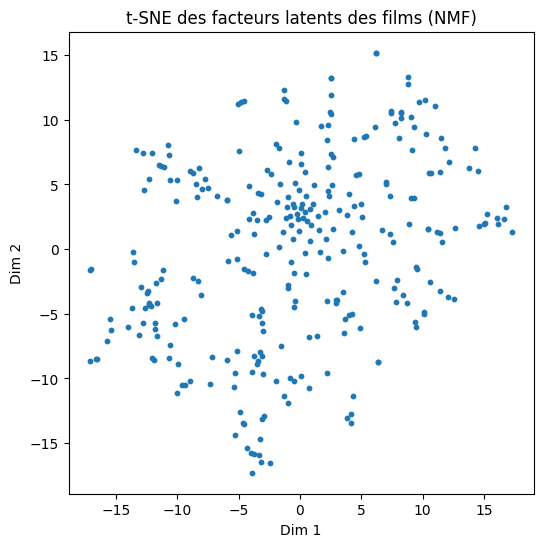

In [60]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# items = colonnes de la matrice train
item_ids = R_train_df.columns.values

np.random.seed(42)
sample_idx = np.random.choice(len(item_ids), size=min(300, len(item_ids)), replace=False)

X = H.T[sample_idx]   # (n_items_sample, n_factors)

X2 = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30
).fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X2[:,0], X2[:,1], s=10)
plt.title("t-SNE des facteurs latents des films (NMF)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


Session 5 — Deep Learning
5.1 Embeddings + MLP (prédiction de notes) — Keras

In [61]:
import tensorflow as tf
from tensorflow.keras import layers, Model

from sklearn.metrics import mean_squared_error
import numpy as np

def rmse_score(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


# re-index pour DL (dense IDs)
u_ids = np.sort(train_df.user_id.unique())
i_ids = np.sort(train_df.item_id.unique())
u_map = {u:i for i,u in enumerate(u_ids)}
i_map = {it:i for i,it in enumerate(i_ids)}

train_X_u = train_df.user_id.map(u_map).values
train_X_i = train_df.item_id.map(i_map).values
train_y   = train_df.rating.values.astype(np.float32)

test_X_u = test_df.user_id.map(u_map)
test_X_i = test_df.item_id.map(i_map)
valid_mask = (~test_X_u.isna()) & (~test_X_i.isna())

test_X_u = test_X_u[valid_mask].astype(int).values
test_X_i = test_X_i[valid_mask].astype(int).values
test_y   = test_df[valid_mask].rating.values.astype(np.float32)

n_users_dl = len(u_ids)
n_items_dl = len(i_ids)
emb_dim = 32

u_in = layers.Input(shape=(1,))
i_in = layers.Input(shape=(1,))

u_emb = layers.Embedding(n_users_dl, emb_dim)(u_in)
i_emb = layers.Embedding(n_items_dl, emb_dim)(i_in)

x = layers.Concatenate()([layers.Flatten()(u_emb), layers.Flatten()(i_emb)])
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
out = layers.Dense(1)(x)

mlp = Model([u_in, i_in], out)
mlp.compile(optimizer="adam", loss="mse")

t0 = time.time()
mlp.fit([train_X_u, train_X_i], train_y, epochs=5, batch_size=1024, verbose=1)
dl_train_time = time.time()-t0

pred = mlp.predict([test_X_u, test_X_i], verbose=0).ravel()
pred = np.clip(pred, 1, 5)

dl_rmse = rmse_score(test_y, pred)

dl_train_time, dl_rmse


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0210
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9374
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9117
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9038
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8991


(2.8564982414245605, 0.9440979208894343)

In [24]:
def recommend_mlp(user_id, train_df, model, all_items, u_map, i_map, n_rec=10):
    if user_id not in u_map:
        return []
    seen = set(train_df[train_df.user_id==user_id]["item_id"].tolist())
    candidates = [it for it in all_items if it in i_map and it not in seen]
    u_idx = u_map[user_id]

    u_arr = np.full(len(candidates), u_idx)
    i_arr = np.array([i_map[it] for it in candidates])

    scores = model.predict([u_arr, i_arr], verbose=0).ravel()
    scores = np.clip(scores, 1, 5)

    ranked = sorted(zip(candidates, scores), key=lambda x: x[1], reverse=True)[:n_rec]
    return [it for it,_ in ranked]

mlp_recos = {u: recommend_mlp(u, train_df, mlp, all_items, u_map, i_map, n_rec=10) for u in test_users}
mlp_recos


{405: [np.int64(1449),
  np.int64(320),
  np.int64(408),
  np.int64(114),
  np.int64(483),
  np.int64(50),
  np.int64(272),
  np.int64(867),
  np.int64(134),
  np.int64(488)],
 655: [np.int64(1449),
  np.int64(114),
  np.int64(408),
  np.int64(64),
  np.int64(169),
  np.int64(488),
  np.int64(1500),
  np.int64(963),
  np.int64(1203),
  np.int64(174)],
 13: [np.int64(1449),
  np.int64(320),
  np.int64(114),
  np.int64(408),
  np.int64(483),
  np.int64(513),
  np.int64(169),
  np.int64(867),
  np.int64(603),
  np.int64(50)],
 450: [np.int64(1449),
  np.int64(320),
  np.int64(114),
  np.int64(408),
  np.int64(64),
  np.int64(513),
  np.int64(483),
  np.int64(169),
  np.int64(867),
  np.int64(603)],
 276: [np.int64(1449),
  np.int64(320),
  np.int64(114),
  np.int64(408),
  np.int64(483),
  np.int64(513),
  np.int64(867),
  np.int64(134),
  np.int64(480),
  np.int64(12)]}

In [25]:
from scipy.sparse import csr_matrix

# user×item (train)
R_train = train_df.pivot_table(index="user_id", columns="item_id", values="rating").fillna(0)
u_index = R_train.index.values
i_cols = R_train.columns.values

X = R_train.values.astype(np.float32) / 5.0  # normalisation

inp = layers.Input(shape=(X.shape[1],))
h = layers.Dense(256, activation="relu")(inp)
h = layers.Dense(64, activation="relu")(h)
z = layers.Dense(32, activation="relu")(h)              # latent
h2 = layers.Dense(64, activation="relu")(z)
h2 = layers.Dense(256, activation="relu")(h2)
out = layers.Dense(X.shape[1], activation="sigmoid")(h2)

ae = Model(inp, out)
ae.compile(optimizer="adam", loss="mse")
ae.fit(X, X, epochs=5, batch_size=64, verbose=1)

def recommend_autoencoder(user_id, train_df, ae, R_train, n_rec=10):
    if user_id not in R_train.index:
        return []
    seen = set(train_df[train_df.user_id==user_id]["item_id"].tolist())

    user_vec = R_train.loc[user_id].values.astype(np.float32).reshape(1,-1)/5.0
    recon = ae.predict(user_vec, verbose=0).ravel()

    # rank items non vus
    candidates = [it for it in R_train.columns if it not in seen]
    cand_idx = [np.where(R_train.columns==it)[0][0] for it in candidates]
    ranked = sorted(zip(candidates, recon[cand_idx]), key=lambda x:x[1], reverse=True)[:n_rec]
    return [it for it,_ in ranked]

ae_recos = {u: recommend_autoencoder(u, train_df, ae, R_train, n_rec=10) for u in test_users}
ae_recos


Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1765
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0308
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0278
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0279
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0278


{405: [50, 127, 100, 258, 313, 269, 286, 300, 288, 1],
 655: [258, 174, 1, 7, 168, 294, 173, 172, 121, 2],
 13: [50, 3, 5, 6, 10, 15, 16, 17, 18, 19],
 450: [127, 98, 222, 5, 6, 8, 9, 14, 15, 16],
 276: [127, 286, 98, 117, 294, 172, 4, 6, 10, 12]}

In [26]:
# Construire séquences par user
seq_df = ratings.sort_values(["user_id","timestamp"])
seqs = seq_df.groupby("user_id")["item_id"].apply(list)

# vocab items
all_item_seq = np.unique(ratings["item_id"])
item2idx = {it:i+1 for i,it in enumerate(all_item_seq)}  # 0 = padding
idx2item = {v:k for k,v in item2idx.items()}
vocab_size = len(item2idx) + 1

# créer dataset (X_seq -> y_next)
maxlen = 20
X_seq, y_next = [], []
for u, items_list in seqs.items():
    idxs = [item2idx[it] for it in items_list if it in item2idx]
    for t in range(2, len(idxs)):
        x = idxs[max(0,t-maxlen):t]
        y = idxs[t]
        X_seq.append(x)
        y_next.append(y)

X_seq = tf.keras.preprocessing.sequence.pad_sequences(X_seq, maxlen=maxlen, padding="pre")
y_next = np.array(y_next)

# modèle LSTM
inp = layers.Input(shape=(maxlen,))
emb = layers.Embedding(vocab_size, 64, mask_zero=True)(inp)
x = layers.LSTM(64)(emb)
x = layers.Dense(128, activation="relu")(x)
out = layers.Dense(vocab_size, activation="softmax")(x)

lstm = Model(inp, out)
lstm.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
lstm.fit(X_seq, y_next, epochs=2, batch_size=1024, verbose=1)

def recommend_next_items(user_id, ratings_df, n_rec=10):
    user_hist = ratings_df[ratings_df.user_id==user_id].sort_values("timestamp")["item_id"].tolist()
    if len(user_hist) < 2:
        return []
    idxs = [item2idx[it] for it in user_hist if it in item2idx][-maxlen:]
    x = tf.keras.preprocessing.sequence.pad_sequences([idxs], maxlen=maxlen, padding="pre")
    probs = lstm.predict(x, verbose=0).ravel()

    seen = set(user_hist)
    cand = [(idx2item[i], probs[i]) for i in range(1, vocab_size) if idx2item[i] not in seen]
    cand.sort(key=lambda x: x[1], reverse=True)
    return [it for it,_ in cand[:n_rec]]

lstm_recos = {u: recommend_next_items(u, ratings, n_rec=10) for u in test_users}
lstm_recos


Epoch 1/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 6.8893
Epoch 2/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 6.4847


{405: [np.int64(145),
  np.int64(158),
  np.int64(572),
  np.int64(809),
  np.int64(155),
  np.int64(167),
  np.int64(412),
  np.int64(800),
  np.int64(801),
  np.int64(928)],
 655: [np.int64(546),
  np.int64(168),
  np.int64(151),
  np.int64(235),
  np.int64(230),
  np.int64(496),
  np.int64(154),
  np.int64(177),
  np.int64(147),
  np.int64(95)],
 13: [np.int64(395),
  np.int64(386),
  np.int64(575),
  np.int64(80),
  np.int64(577),
  np.int64(1228),
  np.int64(388),
  np.int64(373),
  np.int64(364),
  np.int64(728)],
 450: [np.int64(678),
  np.int64(333),
  np.int64(289),
  np.int64(268),
  np.int64(323),
  np.int64(327),
  np.int64(879),
  np.int64(303),
  np.int64(358),
  np.int64(690)],
 276: [np.int64(286),
  np.int64(259),
  np.int64(327),
  np.int64(690),
  np.int64(326),
  np.int64(319),
  np.int64(304),
  np.int64(895),
  np.int64(275),
  np.int64(312)]}

In [28]:
k = 10
results = []

# =========================
# SVD (TruncatedSVD)
# =========================
m = precision_recall_ndcg_at_k(svd_recos, test_df, k=k)
results.append({
    "Method": "SVD (TruncatedSVD)",
    "TrainTime": globals().get("svd_train_time", np.nan),
    "RMSE": globals().get("svd_rmse", np.nan),
    **m
})

# =========================
# NMF (remplace ALS)
# =========================
m = precision_recall_ndcg_at_k(nmf_recos, test_df, k=k)
results.append({
    "Method": "NMF (Matrix Factorization)",
    "TrainTime": globals().get("nmf_train_time", np.nan),
    "RMSE": globals().get("nmf_rmse", np.nan),
    **m
})

# =========================
# Deep Learning – Embedding + MLP
# =========================
m = precision_recall_ndcg_at_k(mlp_recos, test_df, k=k)
results.append({
    "Method": "DL Embedding + MLP",
    "TrainTime": globals().get("dl_train_time", np.nan),
    "RMSE": globals().get("dl_rmse", np.nan),
    **m
})

# =========================
# Autoencoder
# =========================
m = precision_recall_ndcg_at_k(ae_recos, test_df, k=k)
results.append({
    "Method": "Autoencoder",
    "TrainTime": np.nan,
    "RMSE": np.nan,
    **m
})

# =========================
# LSTM Séquentiel
# =========================
m = precision_recall_ndcg_at_k(lstm_recos, test_df, k=k)
results.append({
    "Method": "LSTM (Sequential)",
    "TrainTime": np.nan,
    "RMSE": np.nan,
    **m
})

summary_df = pd.DataFrame(results)
summary_df


,Method,TrainTime,RMSE,Precision@10,Recall@10,NDCG@10
0,SVD (TruncatedSVD),NaN,2.498893,0.46,0.120882,0.783464
1,NMF (Matrix Factorization),NaN,2.152286,0.52,0.121745,0.714719
2,DL Embedding + MLP,2.448969,0.942368,0.24,0.054700,0.462986
3,Autoencoder,NaN,NaN,0.30,0.076630,0.825342
4,LSTM (Sequential),NaN,NaN,0.00,0.000000,0.000000


In [30]:
def show_recos(user_id, reco_items, title="Reco"):
    print(f"\n=== {title} | User {user_id} ===")
    for it in reco_items[:10]:
        print("-", item_id_to_title.get(it, f"item {it}"))


u = test_users[0]

show_recos(u, svd_recos[u], "SVD (TruncatedSVD)")
show_recos(u, nmf_recos[u], "NMF (Matrix Factorization)")
show_recos(u, mlp_recos[u], "DL – Embedding + MLP")
show_recos(u, ae_recos[u], "Autoencoder")
show_recos(u, lstm_recos[u], "LSTM (Sequential)")



=== SVD (TruncatedSVD) | User 405 ===
- Forrest Gump (1994)
- Mrs. Doubtfire (1993)
- Jurassic Park (1993)
- Pulp Fiction (1994)
- While You Were Sleeping (1995)
- Raising Arizona (1987)
- Batman (1989)
- Vertigo (1958)
- Godfather: Part II, The (1974)
- Dolores Claiborne (1994)

=== NMF (Matrix Factorization) | User 405 ===
- Forrest Gump (1994)
- Pulp Fiction (1994)
- Jurassic Park (1993)
- Mask, The (1994)
- Wizard of Oz, The (1939)
- Mrs. Doubtfire (1993)
- Young Frankenstein (1974)
- Sound of Music, The (1965)
- So I Married an Axe Murderer (1993)
- Scream (1996)

=== DL – Embedding + MLP | User 405 ===
- Pather Panchali (1955)
- Paradise Lost: The Child Murders at Robin Hood Hills (1996)
- Close Shave, A (1995)
- Wallace & Gromit: The Best of Aardman Animation (1996)
- Casablanca (1942)
- Star Wars (1977)
- Good Will Hunting (1997)
- Whole Wide World, The (1996)
- Citizen Kane (1941)
- Sunset Blvd. (1950)

=== Autoencoder | User 405 ===
- Star Wars (1977)
- Godfather, The (1972)

collaboratif item-based et content-based pour pouvoir faire un deploiement


In [35]:
from sklearn.metrics.pairwise import cosine_similarity

# On remplit les NaN par 0 pour le calcul de similarité
R_train_filled = R_train.fillna(0)

item_cosine_train = pd.DataFrame(
    cosine_similarity(R_train_filled.T),
    index=R_train.columns,
    columns=R_train.columns
)

item_cosine_train.iloc[:5, :5]


item_id,1,2,3,4,5
item_id,,,,,
1,1.000000,0.311393,0.253690,0.350312,0.214229
2,0.311393,1.000000,0.216764,0.383544,0.304612
3,0.253690,0.216764,1.000000,0.261066,0.141570
4,0.350312,0.383544,0.261066,1.000000,0.270286
5,0.214229,0.304612,0.141570,0.270286,1.000000


In [36]:
# Reco collaboratif item-based (à partir de R_train et item_cosine)

def recommend_cf_item_based(u, R_train, sim_item, n_rec=10, k_items=20):
    if u not in R_train.index:
        return []
    seen = set(R_train.loc[u].dropna().index)

    preds = []
    for it in sim_item.columns:
        if it in seen:
            continue
        user_ratings = R_train.loc[u].dropna()
        sims = sim_item.loc[it, user_ratings.index].dropna().sort_values(ascending=False).head(k_items)
        if sims.empty:
            continue
        score = (sims * user_ratings.loc[sims.index]).sum() / (np.abs(sims).sum() + 1e-9)
        preds.append((it, score))

    preds.sort(key=lambda x: x[1], reverse=True)
    return [it for it,_ in preds[:n_rec]]


cf_recos = {
    u: recommend_cf_item_based(u, R_train, item_cosine_train, n_rec=10)
    for u in test_users
}


In [37]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def recommend_tfidf(user_id, ratings_df, X_items, movie_id_to_idx, items_df, n_rec=10):
    # films vus par l'utilisateur (dans ratings_df = train_df)
    seen = ratings_df[ratings_df.user_id == user_id]["item_id"].tolist()
    if not seen:
        return []

    idxs = [movie_id_to_idx[i] for i in seen if i in movie_id_to_idx]
    if len(idxs) == 0:
        return []

    # profil utilisateur = moyenne des vecteurs TF-IDF des films vus
    prof = X_items[idxs].mean(axis=0)

    # ✅ conversion np.matrix -> ndarray (shape 1 x n_features)
    prof = np.asarray(prof)
    if prof.ndim == 1:
        prof = prof.reshape(1, -1)

    sims = cosine_similarity(prof, X_items).ravel()
    ranked = np.argsort(-sims)

    seen_set = set(seen)
    recos = []
    for idx in ranked:
        mid = int(items_df.iloc[idx]["item_id"])
        if mid not in seen_set:
            recos.append(mid)
        if len(recos) == n_rec:
            break
    return recos


In [41]:
tfidf_recos = {
    u: recommend_tfidf(u, train_df, X_tfidf, movie_id_to_idx, items, n_rec=10)
    for u in test_users
}

tfidf_recos


{405: [1590, 1481, 49, 785, 1025, 1627, 385, 1102, 1048, 1657],
 655: [1025, 1590, 1528, 1481, 1102, 1048, 49, 785, 1457, 55],
 13: [1025, 1102, 1048, 831, 301, 1609, 785, 1538, 1528, 298],
 450: [1102, 1025, 1058, 1590, 1481, 1457, 720, 129, 1100, 831],
 276: [1025, 976, 769, 49, 785, 1016, 1102, 1048, 568, 1058]}

In [43]:
def make_tsne_items(factors, item_ids, item_id_to_title, n=300, seed=42):
    np.random.seed(seed)
    n = min(n, len(item_ids))
    idx = np.random.choice(len(item_ids), size=n, replace=False)

    X = factors[idx]
    X2 = TSNE(
        n_components=2,
        random_state=seed,
        perplexity=30
    ).fit_transform(X)

    df = pd.DataFrame({
        "x": X2[:, 0],
        "y": X2[:, 1],
        "item_id": np.array(item_ids)[idx]
    })
    df["title"] = df["item_id"].map(item_id_to_title)
    return df


In [44]:
# SVD
svd_item_ids = list(it2i.keys())   # mapping items SVD
emb_svd_2d = make_tsne_items(V, svd_item_ids, item_id_to_title)


In [45]:
nmf_item_ids = R_train_df.columns.values
emb_nmf_2d = make_tsne_items(H.T, nmf_item_ids, item_id_to_title)


In [46]:
emb2d_dict = {
    "SVD (TruncatedSVD)": emb_svd_2d,
    "NMF (Matrix Factorization)": emb_nmf_2d
}


In [48]:
import pickle, os

os.makedirs("artifacts", exist_ok=True)

objects_to_save = {
    "cf_recos": cf_recos,
    "tfidf_recos": tfidf_recos,
    "svd_recos": svd_recos,
    "nmf_recos": nmf_recos,
    "mlp_recos": mlp_recos,
    "ae_recos": ae_recos,
    "lstm_recos": lstm_recos,
    "summary_df": summary_df,
    "item_id_to_title": item_id_to_title,
    "emb2d_dict": emb2d_dict
}

with open("artifacts/reco_objects.pkl", "wb") as f:
    pickle.dump(objects_to_save, f)

print("✅ reco_objects.pkl créé avec succès")


✅ reco_objects.pkl créé avec succès
